# 1. Setup and load data

### 1.1 Install dependencies and setup

In [5]:
! pip install tensorflow opencv-python matplotlib Pillow

In [1]:
! pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
astunparse                   1.6.3
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
contourpy                    1.1.0
cycler                       0.11.0
flatbuffers                  23.5.26
fonttools                    4.42.0
gast                         0.4.0
google-auth                  2.22.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.56.2
h5py                         3.9.0
idna                         3.4
keras                        2.13.1
kiwisolver                   1.4.4
libclang                     16.0.6
Markdown                     3.4.4
MarkupSafe                   2.1.3
matplotlib                   3.7.2
numpy                        1.24.3
oauthlib                     3.2.2
opencv-python                4.8.0.74
opt-einsum                   3.3.0


In [1]:
import tensorflow as tf
import os

2023-08-08 10:02:19.123492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1.2 Remove doggy images

In [2]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

/var/folders/hs/0znq5pvd1rg4w2pw9pmm7t700000gn/T/ipykernel_60682/2666744909.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
data_dir = '../data'

In [4]:
image_ext = ['jpeg', 'jpg',  'png', 'bmp']

In [5]:
for image_class in os.listdir(data_dir):    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            pil_img = Image.open(image_path)
            img = np.array(pil_img)
            tip = pil_img.format.lower()
            if tip not in image_ext:
                print(f'The following image has a not allowed format:\n{image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issues with the following image: {image_path}')
            os.remove(image_path)

### 1.3 Load data

In [6]:
data = tf.keras.utils.image_dataset_from_directory('../data') # it creates a generator

Found 304 files belonging to 2 classes.


In [7]:
data_iterator = data.as_numpy_iterator() # allow us to iterate through the data

In [8]:
batch = data_iterator.next() # grab the data

In [9]:
# NOTE
# 0 -> happy people
# 1 -> sad people
batch[1]

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

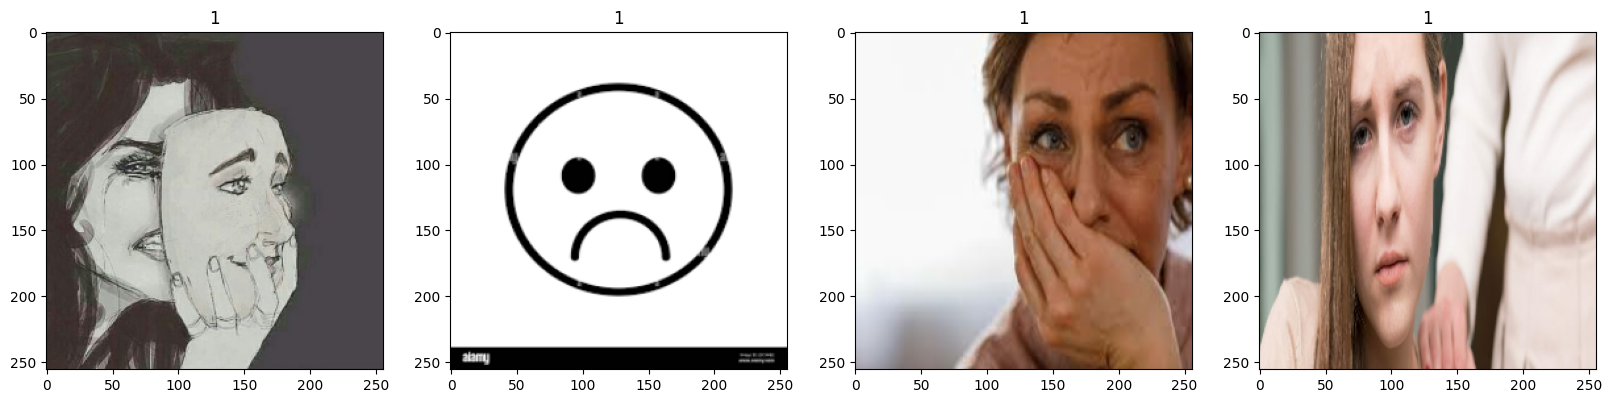

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Process data

### 2.1 Scale data

In [11]:
data = data.map(lambda x, y: (x/255, y))

In [12]:
scaled_data_iterator = data.as_numpy_iterator()

In [13]:
scaled_data_iterator.next()

(array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

### 2.2 Split data in different set (avoid overfitting)

In [14]:
len(data)

10

In [15]:
train_set = int(len(data) * .7)
val_set = int(len(data) * .2)
test_set = int(len(data) * .1)

In [16]:
train_set + val_set + test_set == len(data) # check partition

True

In [17]:
train = data.take(train_set)
val = data.skip(train_set).take(val_set)
test = data.skip(train_set + val_set).take(test_set)
# Check with Notion an alternative to create the different sets

# 3. Deep Model

### 3.1 Build deep learning model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [35]:
#optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### 3.2 Train

In [37]:
logs_dir = '../logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 13s 1s/step - loss: 0.8152 - accuracy: 0.4732 - val_loss: 0.6438 - val_accuracy: 0.7344
Epoch 2/20
7/7 [==============================] - 11s 1s/step - loss: 0.5967 - accuracy: 0.7054 - val_loss: 0.5350 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 13s 1s/step - loss: 0.5692 - accuracy: 0.7455 - val_loss: 0.5017 - val_accuracy: 0.8594
Epoch 4/20
7/7 [==============================] - 14s 2s/step - loss: 0.5275 - accuracy: 0.7098 - val_loss: 0.4740 - val_accuracy: 0.8906
Epoch 5/20
7/7 [==============================] - 17s 2s/step - loss: 0.4715 - accuracy: 0.8438 - val_loss: 0.4121 - val_accuracy: 0.8125
Epoch 6/20
7/7 [==============================] - 12s 1s/step - loss: 0.3577 - accuracy: 0.8705 - val_loss: 0.2640 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 15s 1s/step - loss: 0.2631 - accuracy: 0.8973 - val_loss: 0.2006 - val_accuracy: 0.9531
Epoch 8/20
7/7 [==================

In [41]:
hist.history

{'loss': [0.8151522874832153,
  0.5966747999191284,
  0.5692440271377563,
  0.5275140404701233,
  0.4714888036251068,
  0.3576870560646057,
  0.26306474208831787,
  0.25300344824790955,
  0.39994189143180847,
  0.27101799845695496,
  0.21640072762966156,
  0.15699736773967743,
  0.09168477356433868,
  0.0544540099799633,
  0.04252404719591141,
  0.0320897214114666,
  0.03260224312543869,
  0.020059529691934586,
  0.005251582711935043,
  0.009596501477062702],
 'accuracy': [0.4732142984867096,
  0.7053571343421936,
  0.7455357313156128,
  0.7098214030265808,
  0.84375,
  0.8705357313156128,
  0.8973214030265808,
  0.8973214030265808,
  0.8080357313156128,
  0.9508928656578064,
  0.9330357313156128,
  0.9508928656578064,
  0.9821428656578064,
  0.9821428656578064,
  0.9955357313156128,
  0.9910714030265808,
  0.9910714030265808,
  0.9955357313156128,
  1.0,
  0.9955357313156128],
 'val_loss': [0.643791675567627,
  0.5349780321121216,
  0.5017409920692444,
  0.4739574193954468,
  0.412081

### 3.3 Plot Performance

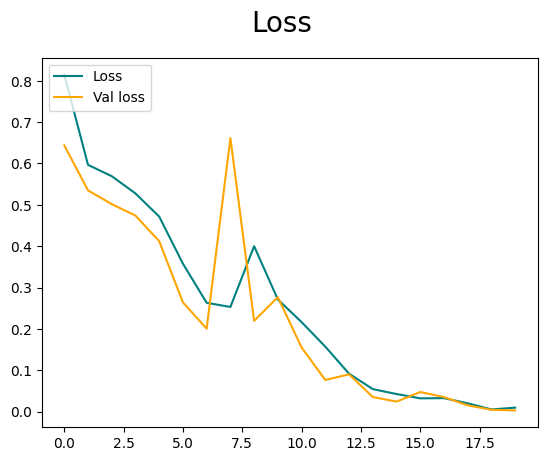

In [42]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Val loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

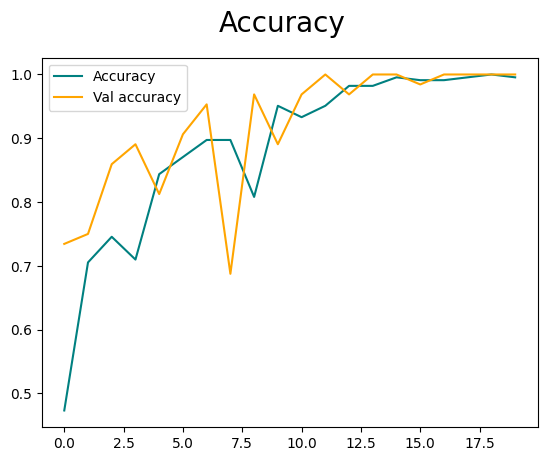

In [43]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluate performance

### 4.1 Evaluate

In [48]:
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy 

In [45]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [46]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 215ms/step


In [47]:
print(f'Precision: {pre.result().numpy()}\nRecall: {re.result().numpy()}\nAccuracy: {acc.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


### 4.2 Test

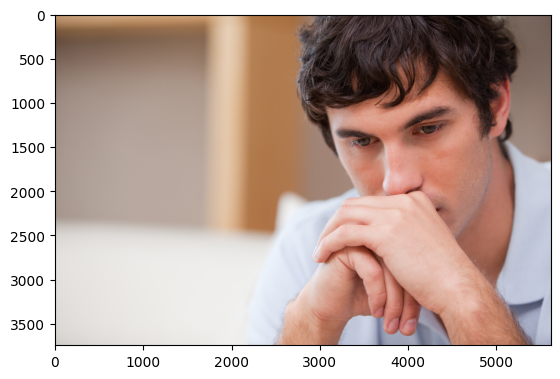

In [60]:
sad_img_test = cv2.imread('../test_sad.jpg')
plt.imshow(cv2.cvtColor(sad_img_test, cv2.COLOR_BGR2RGB))
plt.show()

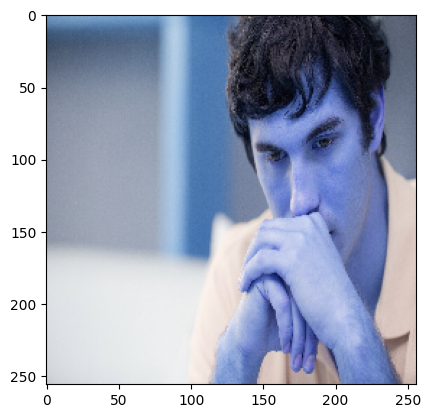

In [61]:
sad_img_test_resize = tf.image.resize(sad_img_test, (256, 256))
plt.imshow(sad_img_test_resize.numpy().astype(int))
plt.show()

In [62]:
yhat = model.predict(np.expand_dims(sad_img_test_resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [63]:
yhat

array([[0.9998638]], dtype=float32)

In [64]:
if yhat > 0.5:
    print('This is a SAD image :(')
else:
    print('This is a HAPPY image :)')

This is a SAD image :(


# 5. Save model

### 5.1 Save the model

In [65]:
from tensorflow.keras.models import load_model

In [70]:
model.save(os.path.join('../models', 'imageClassifierNewVersion.keras')) # saving as .h5 is for tensorflow 1.X

In [71]:
new_model = load_model(os.path.join('../models', 'imageClassifierNewVersion.keras'))

In [73]:
yhatnew = new_model.predict(np.expand_dims(sad_img_test_resize/255, 0))

1/1 [==============================] - 0s 28ms/step
